# DEEP LEARNING
### TOPIC : DOGS V/S CATS IMAGE CLASSIFICATION USING CNN, VGG-16 AND VGG-19

## PART 2 : USING ```VGG-16``` MODEL
### INTRODUCTION
This is a image classification project from our team. In this project, as part 2 we applied ```VGG-16``` for image classification.
The training archive contains 25,000 images of dogs and cats. Train the algorithm on these files and predict the labels
(1 = dog, 0 = cat).

### IMPORTING MODULES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense,Conv2D, MaxPooling2D,GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.models import Model
from keras import optimizers
import warnings
warnings.filterwarnings('ignore')

### DOWNLOAD THE DATASET

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

### UNZIP THE DATASET

In [ ]:
!unzip kagglecatsanddogs_3367a.zip

In [ ]:
# For saving the resulting files in the drive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### IMAGE AUGMENTATION, TRAIN AND TEST GENERATORS

In [ ]:
# Image dimensions
img_width = 150
img_height = 150
batch_size = 20
input_shape = (img_width, img_height, 3)

In [ ]:
# All images will be rescaled by 1./255. which is normalization
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.3,
    zoom_range = [0.6, 1.0],
    brightness_range = [0.6, 1.0],
    rotation_range = 90,
    horizontal_flip = True,
    validation_split = 0.2
)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(
    'PetImages',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    seed = 42,
    subset = 'training'
)
valid_generator = train_datagen.flow_from_directory(
    'PetImages',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    #class_mode = 'binary',
    class_mode = 'categorical',
    seed = 42,
    subset = 'validation'
    
)
#X, y = next(train_generator)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


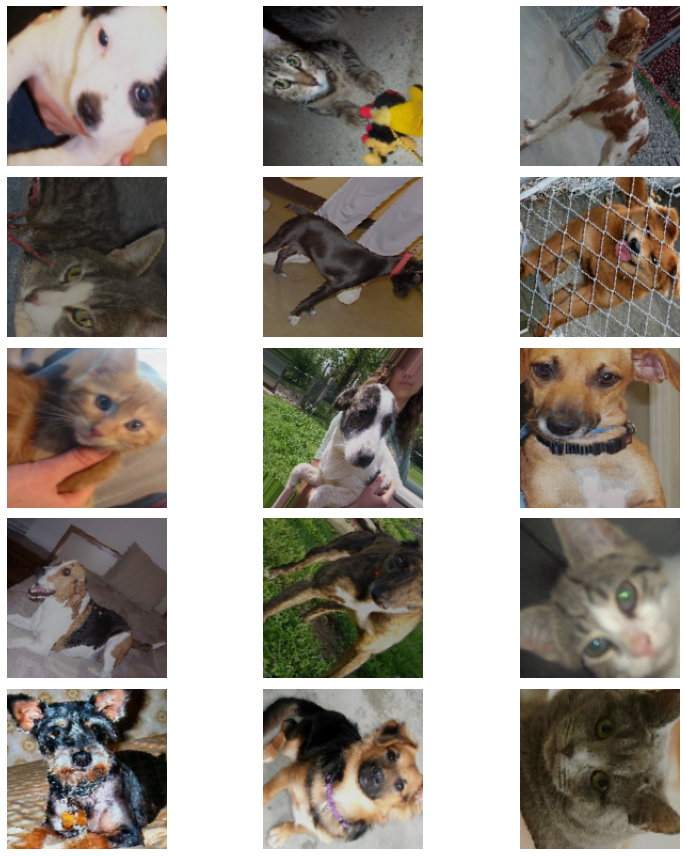

In [ ]:
# To show images randomly after doing above operations

plt.figure(figsize = (12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

### MODEL CREATION OF VGG-16
#### BUILD NETWORK
The architecture of VGG-16 used in this project is shown as follow <br>

![VGG](https://www.researchgate.net/publication/342388869/figure/fig1/AS:905607955615747@1592925170508/Architecture-of-the-VGG-16-deep-convolutional-neural-network-DCNN-Simonyan.png)
<br>

In [ ]:
from keras.applications import VGG16 # The important module for VGG16 model
pre_trained_model = VGG16(input_shape = (150, 150, 3), include_top = False, weights = "imagenet")

for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

In [ ]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation = 'relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
#x = Dense(1, activation='sigmoid')(x)
x = Dense(2, activation = 'softmax')(x)
model = Model(pre_trained_model.input, x)

In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.SGD(learning_rate = 1e-4, momentum = 0.9),
              metrics=['acc'])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, patience = 20, verbose = 0, mode = 'auto')
callbacks = [earlystop]

### TRAINING THE MODEL

In [ ]:
history = model.fit(
            train_generator,
            validation_data = valid_generator,
            steps_per_epoch = 100,
            epochs = 25,
            validation_steps = 50,
            verbose = 1,
            callbacks = callbacks
            )

Epoch 1/25
100/100 [==============================] - 411s 4s/step - loss: 0.7476 - acc: 0.5415 - val_loss: 0.6614 - val_acc: 0.6540
Epoch 2/25
100/100 [==============================] - 386s 4s/step - loss: 0.6934 - acc: 0.5745 - val_loss: 0.6196 - val_acc: 0.7090
Epoch 3/25
100/100 [==============================] - 463s 5s/step - loss: 0.6476 - acc: 0.6535 - val_loss: 0.5930 - val_acc: 0.7310
Epoch 4/25
100/100 [==============================] - 423s 4s/step - loss: 0.6076 - acc: 0.6895 - val_loss: 0.5525 - val_acc: 0.7710
Epoch 5/25
100/100 [==============================] - 394s 4s/step - loss: 0.5677 - acc: 0.7260 - val_loss: 0.5067 - val_acc: 0.7900
Epoch 6/25
100/100 [==============================] - 350s 4s/step - loss: 0.5261 - acc: 0.7615 - val_loss: 0.4927 - val_acc: 0.7830
Epoch 7/25
100/100 [==============================] - 284s 3s/step - loss: 0.5094 - acc: 0.7620 - val_loss: 0.4640 - val_acc: 0.7930
Epoch 8/25
100/100 [==============================] - 271s 3s/step - 

### GRAPHS AND OTHER STATISTICS

Text(0.5, 1.0, 'Training and validation loss')

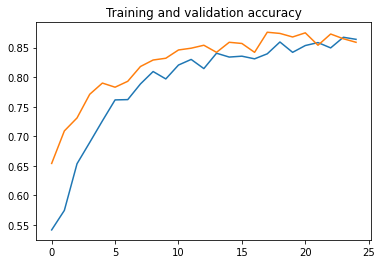

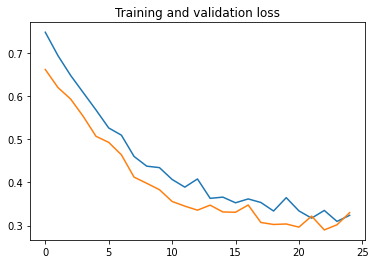

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
acc      = history.history[     'acc' ]
val_acc  = history.history[ 'val_acc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

# ------------------------------------------------
# Plot training and validation loss per epoch
# ------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss')

In [ ]:
# Save the model
from keras.models import load_model
model.save('VGG16_MODEL.h5')
model.save_weights('VGG16_MODEL_WEIGHTS.h5')

In [ ]:
import keras
new_model = keras.models.load_model('VGG16_MODEL.h5')

In [ ]:
val_loss, val_acc = model.evaluate(valid_generator)  # Evaluate the out of sample data with model
#print(val_loss)  # Model's loss (error)

250/250 [==============================] - 58s 233ms/step - loss: 0.3184 - acc: 0.8526


In [ ]:
print(val_acc)  # Model's accuracy

0.8525999784469604


### TESTING RANDOM IMAGES WITH THE TRAINED MODEL

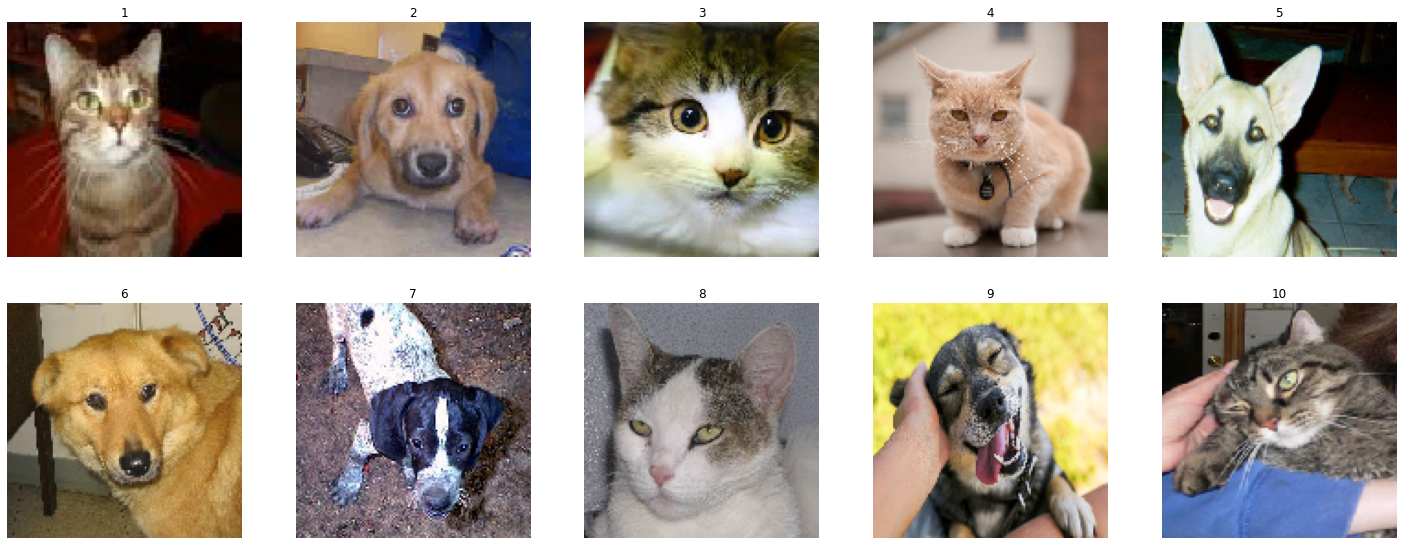

1/1 [==============================] - 1s 836ms/step
1


,Cat,Dog
0,1.0,2.196885e-08


1/1 [==============================] - 0s 140ms/step
2


,Cat,Dog
0,4.242851e-09,1.0


1/1 [==============================] - 0s 148ms/step
3


,Cat,Dog
0,1.0,1.461403e-07


1/1 [==============================] - 0s 137ms/step
4


,Cat,Dog
0,1.0,2.233209e-09


1/1 [==============================] - 0s 140ms/step
5


,Cat,Dog
0,0.679279,0.320721


1/1 [==============================] - 0s 139ms/step
6


,Cat,Dog
0,0.000002,0.999998


1/1 [==============================] - 0s 141ms/step
7


,Cat,Dog
0,0.000006,0.999994


1/1 [==============================] - 0s 128ms/step
8


,Cat,Dog
0,1.0,4.560669e-07


1/1 [==============================] - 0s 128ms/step
9


,Cat,Dog
0,0.00022,0.99978


1/1 [==============================] - 0s 137ms/step
10


,Cat,Dog
0,1.0,3.426828e-07


In [ ]:
rows = 5
columns = 5

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

fig = plt.figure(figsize = (25, 25))
for i in range(1, 11):
  fig.add_subplot(rows, columns, i)
  img = image.load_img('/TestImages/{}.jpg'.format(i), target_size=(128,128))
  plt.imshow(img)
  plt.axis('off')
  plt.title(i)
plt.show()


from IPython.display import display

# Predicts the dog% and cat% for each image
i = 1
import PIL.Image as Image
for i in range(1, 11):
  x = Image.open(('/TestImages/{}.jpg').format(i)).resize((150, 150))
  x = np.array(x) / 255.0
  new_model = tf.keras.models.load_model ('VGG16_MODEL.h5')
  result = new_model.predict(x[np.newaxis, ...])
  df = pd.DataFrame(data = result,columns = ['Cat','Dog'])
  print(i) # Index purpose
  display(df)

### SUMMARY
- The accuracy of the VGG-16 model is higher compared to CNN with comparitively less number of epochs.
- A little more number of epochs would have increased the accuracy.
- We can see a detailed comparison of both the models by seeing the evaluation outputs.

THANK YOU !!!